In [39]:
import pandas as pd
import numpy as np
import os 
from pathlib import Path
import matplotlib.pyplot as plt

from load_data import *

from opt import get_LJs, get_DEs, fit_func, get_freeDEs, get_freeLJs
from plot import plot_energy_MSE, eval_2d_LJ, eval_2d_DE, eval_2d_freeDE

from opt import FF

bounds_4 = [(0.0001, 3.9), (0.0001, 3.9), (0.00001, 2), (0.00001, 2)]
bounds_6 = [(0.0001, 3.9), (0.0001, 3.9), (0.00001, 2), (0.00001, 2), (1, 20), (1, 20)]
bounds_7 = [(0.0001, 3.9), (0.0001, 3.9), (0.00001, 2), (0.00001, 2), (1, 20), (1, 20), (1, 20)]

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2


def get_energy(path):
    lines = open(path).readlines()
    try:
        ccsdt, mp2, hf = (float(x) for x in lines[-3].split())
        return ccsdt, mp2, hf
    except ValueError:
        return None
    
def plot_2d(ff, lim=True):
    ff.set_dists({"OO": OO_dim, "OH": OH_dim, "HH": HH_dim})

    dimer_ccsdt = pd.read_csv("dimers_ccsdt.csv")
    len(dimer_ccsdt)
    dimer_ccsdt["ETOT"] = dimer_ccsdt["int_CCSDT"]
    dimer_ccsdt["ele"] = dimer_ccsdt["int_CCSDT"]
    dimer_ccsdt["ELST"] = dimer_ccsdt["int_CCSDT"]


    ff.data = dimer_ccsdt
    _ = ff.get_best_df()
    dist=[0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 7, 8]

    plt.plot(dist, _["LJ"])
    if lim:
        plt.xlim(0.75,5)
        plt.ylim(-1,1)
    plt.axhline(0, c="k")
    

bach_base = Path("/home/boittier/pcbach")
cluster_path = bach_base / "molpro_energies"
singles_path = bach_base / "3body/f12"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Loading data

In [2]:
cluster_files = [_ for _ in cluster_path.iterdir() if _.is_dir()]
singles_files = [_ for _ in singles_path.iterdir() if _.is_dir()]


In [3]:
cluster_dict = {_.name : [x for x in _.iterdir() if x.name.endswith("out") and x.name.startswith("t")] for _ in cluster_files}
singles_dict = {_.name : [x for x in _.iterdir() if x.name.endswith("out") and x.name.startswith("t")] for _ in singles_files}

In [4]:
df = pd.DataFrame({"cluster_path": cluster_dict, "singles_paths": singles_dict})

In [5]:
failed = list(df[df["singles_paths"].str.len() == 0].index)
success = df[df["singles_paths"].str.len() != 0]
# " ".join(failed)

In [6]:
df["cluster_E"] = df["cluster_path"].apply(lambda x: get_energy(x[0]))
df["c_HF"] = df["cluster_E"] .apply(lambda x: x[2] if x is not None else None)
df["c_MP2"] = df["cluster_E"] .apply(lambda x: x[1] if x is not None else None)
df["c_CCSDT"] = df["cluster_E"] .apply(lambda x: x[0] if x is not None else None)

In [7]:
df["singles_E"] = df["singles_paths"].apply(lambda x: [get_energy(_) for _ in x])
df["s_HF"] = df["singles_E"].apply(lambda x: np.sum([_[2] for _ in x]) if x is not None else None)
df["s_MP2"] = df["singles_E"].apply(lambda x: np.sum([_[1] for _ in x]) if x is not None else None)
df["s_CCSDT"] = df["singles_E"].apply(lambda x: np.sum([_[0] for _ in x]) if x is not None else None)

In [8]:
H2kcalmol = 627.503
df["int_HF"] = (df["c_HF"]  - df["s_HF"]) * H2kcalmol
df["int_MP2"] = (df["c_MP2"]  - df["s_MP2"]) * H2kcalmol
df["int_CCSDT"] = (df["c_CCSDT"]  - df["s_CCSDT"]) * H2kcalmol

In [9]:
# df[df["cluster_E"].str == "None" ]
# " ".join(df[df["cluster_E"].isnull()].index)

In [10]:
clean_df = df.dropna()

In [11]:
# df = cluster_mdcm
# df = cluster_pc
# df = cluster_kern
# df = cluster_flux


In [12]:
# df

In [13]:
len(clean_df)

157

In [14]:
elec="ele"

def prepare_FF_DE(df, elec="ele", data="int_CCSDT"):
    cluster = df.copy()
    cluster.index = cluster["key"]

    flux_clean = pd.merge(cluster, clean_df, left_index=True, right_index = True)

    test_dict = {a: b for a,b in zip(cluster["key"], OO)}
    OO_df = pd.DataFrame(test_dict).T
    OO_df = pd.merge(OO_df, clean_df, left_index=True, right_index = True)
    OO_np = OO_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], OH)}
    OH_df = pd.DataFrame(test_dict).T
    OH_df = pd.merge(OH_df, clean_df, left_index=True, right_index = True)
    OH_np = OH_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], HH)}
    HH_df = pd.DataFrame(test_dict).T
    HH_df = pd.merge(HH_df, clean_df, left_index=True, right_index = True)
    HH_np = HH_df[[i for i in range(190)]].to_numpy()

    df = flux_clean
    # df["ETOT"] = df["int_HF"]
    df["ETOT"] = df[data]

    ff = FF(df, {"OO": OO_np, "OH": OH_np, "HH": HH_np}, get_DEs, elec=elec)
    return ff

def prepare_FF_freeDE(df, elec="ele",data="int_CCSDT"):
    cluster = df.copy()
    cluster.index = cluster["key"]

    flux_clean = pd.merge(cluster, clean_df, left_index=True, right_index = True)

    test_dict = {a: b for a,b in zip(cluster["key"], OO)}
    OO_df = pd.DataFrame(test_dict).T
    OO_df = pd.merge(OO_df, clean_df, left_index=True, right_index = True)
    OO_np = OO_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], OH)}
    OH_df = pd.DataFrame(test_dict).T
    OH_df = pd.merge(OH_df, clean_df, left_index=True, right_index = True)
    OH_np = OH_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], HH)}
    HH_df = pd.DataFrame(test_dict).T
    HH_df = pd.merge(HH_df, clean_df, left_index=True, right_index = True)
    HH_np = HH_df[[i for i in range(190)]].to_numpy()

    df = flux_clean
    # df["ETOT"] = df["int_HF"]
    df["ETOT"] = df[data]

    ff = FF(df, {"OO": OO_np, "OH": OH_np, "HH": HH_np}, get_freeDEs, elec=elec)
    return ff

def prepare_FF_LJ(df, elec="ele",data="int_CCSDT"):
    cluster = df.copy()
    cluster.index = cluster["key"]

    flux_clean = pd.merge(cluster, clean_df, left_index=True, right_index = True)

    test_dict = {a: b for a,b in zip(cluster["key"], OO)}
    OO_df = pd.DataFrame(test_dict).T
    OO_df = pd.merge(OO_df, clean_df, left_index=True, right_index = True)
    OO_np = OO_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], OH)}
    OH_df = pd.DataFrame(test_dict).T
    OH_df = pd.merge(OH_df, clean_df, left_index=True, right_index = True)
    OH_np = OH_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], HH)}
    HH_df = pd.DataFrame(test_dict).T
    HH_df = pd.merge(HH_df, clean_df, left_index=True, right_index = True)
    HH_np = HH_df[[i for i in range(190)]].to_numpy()

    df = flux_clean
    # df["ETOT"] = df["int_HF"]
    df["ETOT"] = df[data]

    ff = FF(df, {"OO": OO_np, "OH": OH_np, "HH": HH_np}, get_LJs, elec=elec)
    return ff

def prepare_FF_freeLJ(df, elec="ele", data="int_CCSDT"):
    cluster = df.copy()
    cluster.index = cluster["key"]

    flux_clean = pd.merge(cluster, clean_df, left_index=True, right_index = True)

    test_dict = {a: b for a,b in zip(cluster["key"], OO)}
    OO_df = pd.DataFrame(test_dict).T
    OO_df = pd.merge(OO_df, clean_df, left_index=True, right_index = True)
    OO_np = OO_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], OH)}
    OH_df = pd.DataFrame(test_dict).T
    OH_df = pd.merge(OH_df, clean_df, left_index=True, right_index = True)
    OH_np = OH_df[[i for i in range(190)]].to_numpy()

    test_dict = {a: b for a,b in zip(cluster["key"], HH)}
    HH_df = pd.DataFrame(test_dict).T
    HH_df = pd.merge(HH_df, clean_df, left_index=True, right_index = True)
    HH_np = HH_df[[i for i in range(190)]].to_numpy()

    df = flux_clean
    # df["ETOT"] = df["int_HF"]
    df["ETOT"] = df[data]

    ff = FF(df, {"OO": OO_np, "OH": OH_np, "HH": HH_np}, get_freeLJs, elec=elec)
    return ff


# DE

In [15]:
N = 10

##  MDCM - DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.78101718e+00 1.00000000e-04 2.42199061e-01 1.77744643e-01]


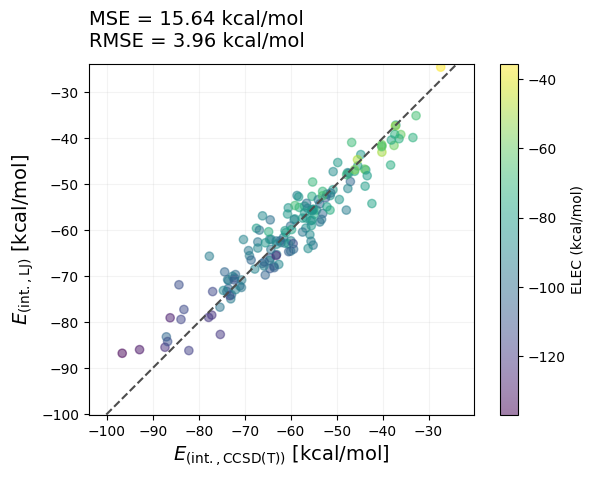

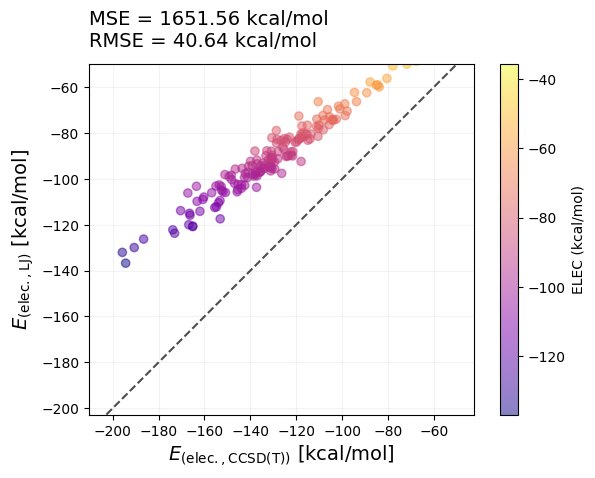

In [16]:
ff = prepare_FF_DE(cluster_mdcm)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_de_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_de_mse_ele.pdf", bbox_inches="tight")

mdcm_de = ff

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


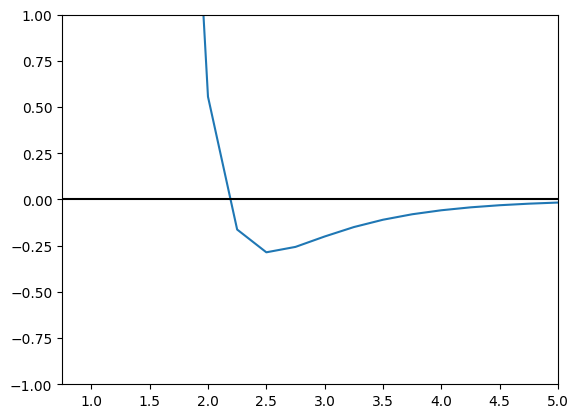

In [40]:
plot_2d(mdcm_de)

##  f-MDCM - DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.76833942 0.07897896 0.23936686 0.04273366]


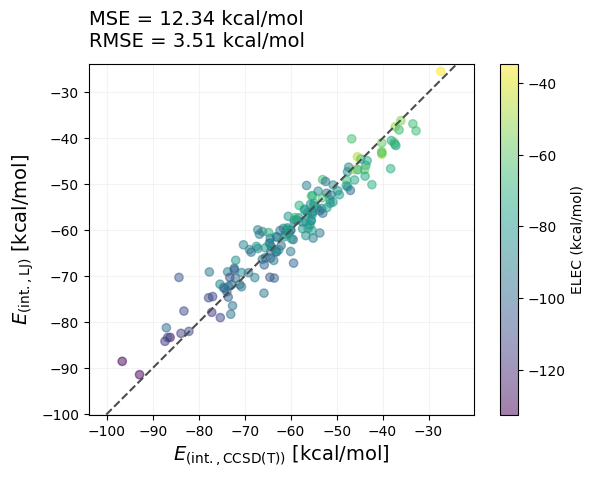

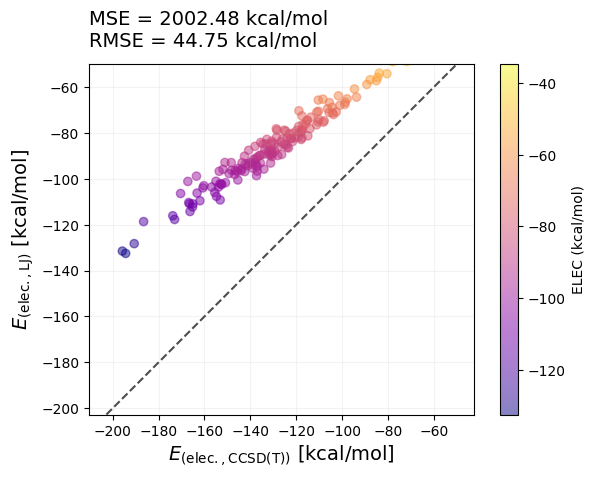

In [17]:
ff = prepare_FF_DE(cluster_flux)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("fmdcm_de_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("fmdcm_de_mse_ele.pdf", bbox_inches="tight")

flux_de = ff

###  2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


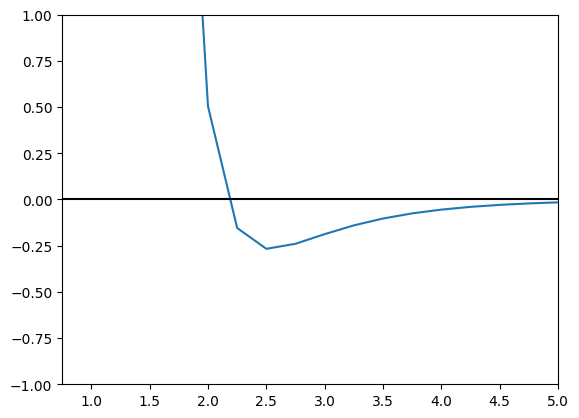

In [41]:
plot_2d(flux_de)

##  Kern-MDCM - DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.7724027  0.15127437 0.22910856 0.02627924]


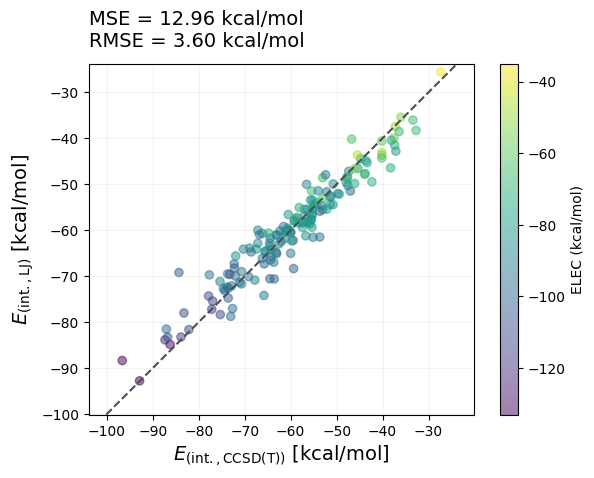

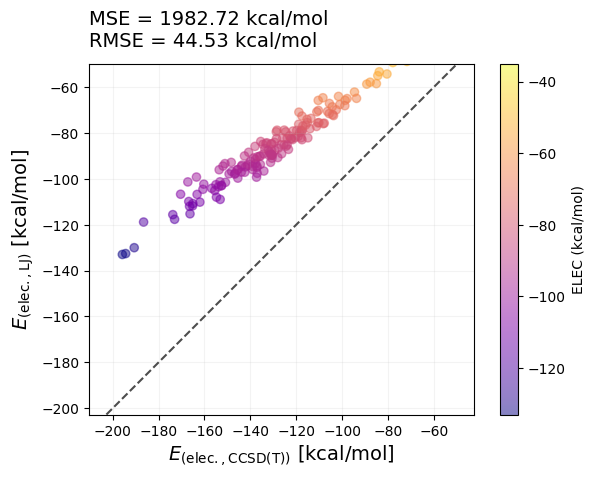

In [18]:
ff = prepare_FF_DE(cluster_kern)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("kern_de_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("kern_de_mse_ele.pdf", bbox_inches="tight")

kern_de = ff

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


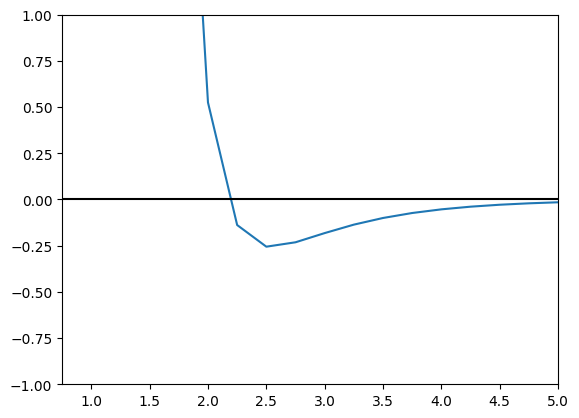

In [42]:
plot_2d(kern_de)

##  ELST - DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.9230722  0.08992079 0.15052226 0.05352616]


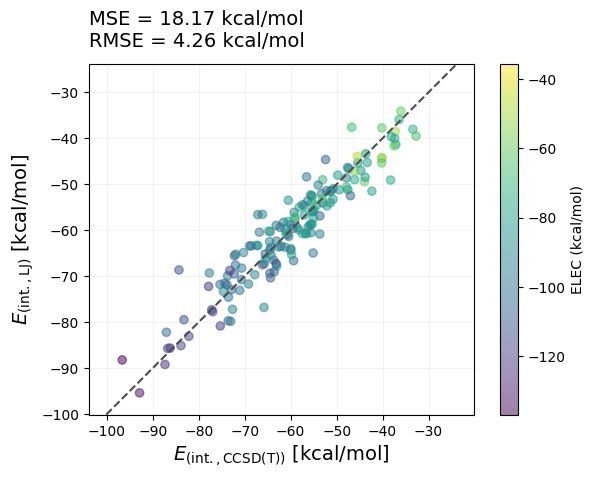

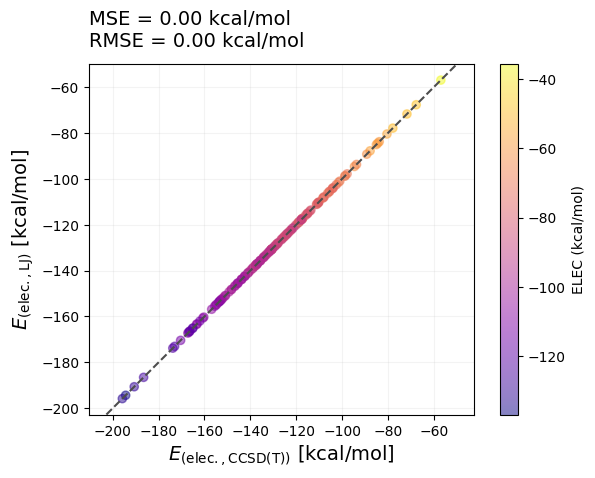

In [55]:
ff = prepare_FF_DE(cluster_mdcm, elec="ELST")

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("elst_de_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", "ELST", 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("elst_de_mse_ele.pdf", bbox_inches="tight")

elst_de = ff

###  2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


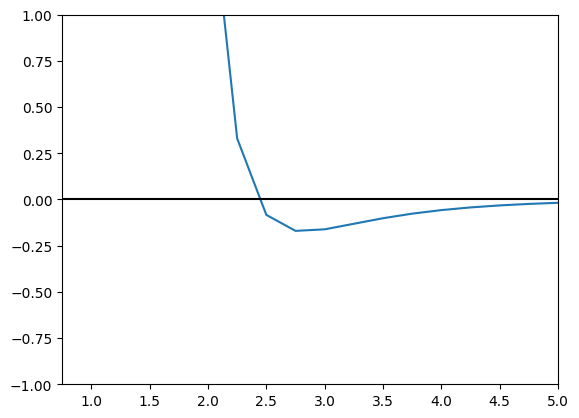

In [56]:
plot_2d(elst_de)

##  PC - DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.70791947e+00 1.00000000e-04 3.71927418e-01 8.59492726e-01]


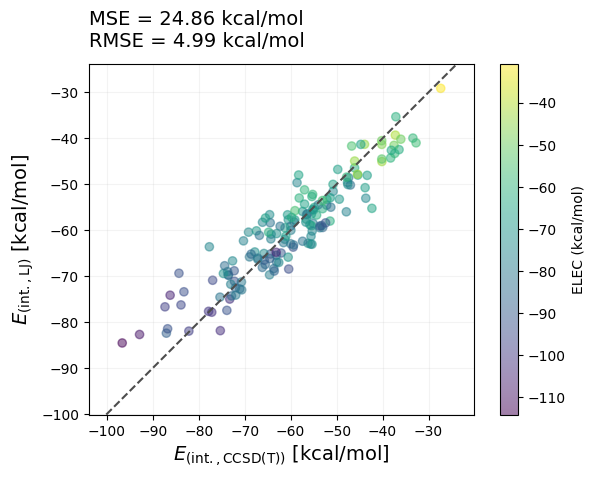

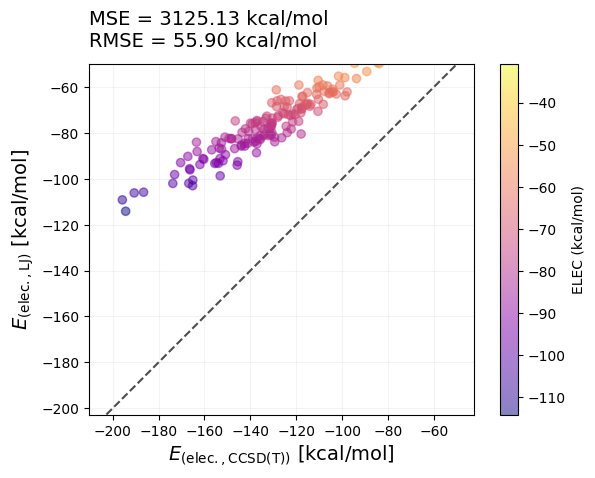

In [20]:
ff = prepare_FF_DE(cluster_pc)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("pc_de_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("pc_de_mse_ele.pdf", bbox_inches="tight")

pc_de = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


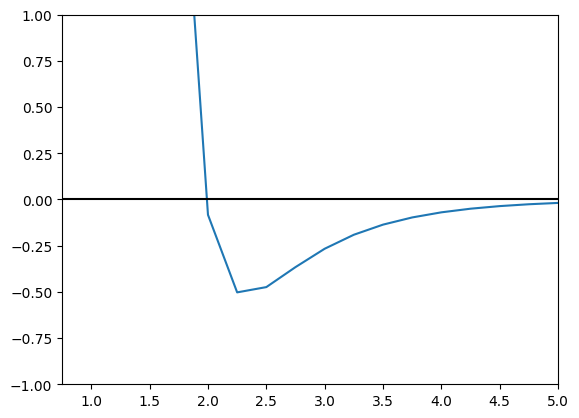

In [44]:
plot_2d(pc_de)

# free DE

In [21]:
N = 10

##  MDCM - free DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.78155316e+00 1.00000000e-04 2.16549291e-01 1.41683303e-01
 1.76514248e+01 4.14949733e+00]


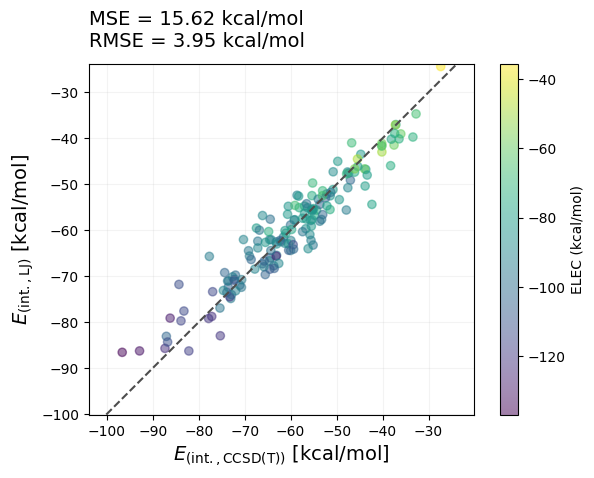

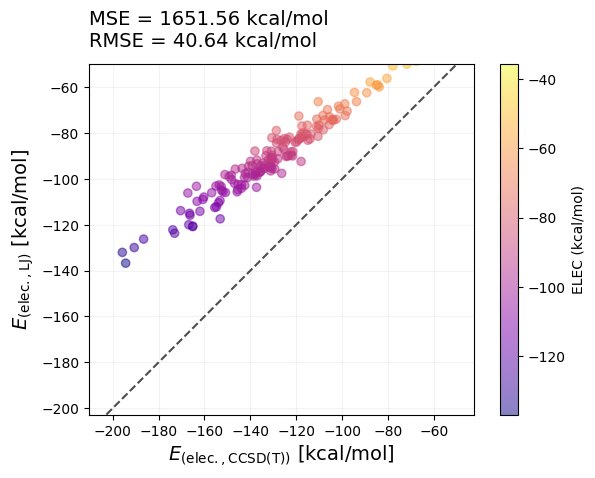

In [22]:
ff = prepare_FF_freeDE(cluster_mdcm)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_6, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_fde_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_fde_mse_ele.pdf", bbox_inches="tight")

mdcm_fde = ff

##  f-MDCM - free DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.79879215e+00 1.00000006e-04 1.53633226e-01 3.66064836e-02
 2.94918723e+00 2.00000000e+01]


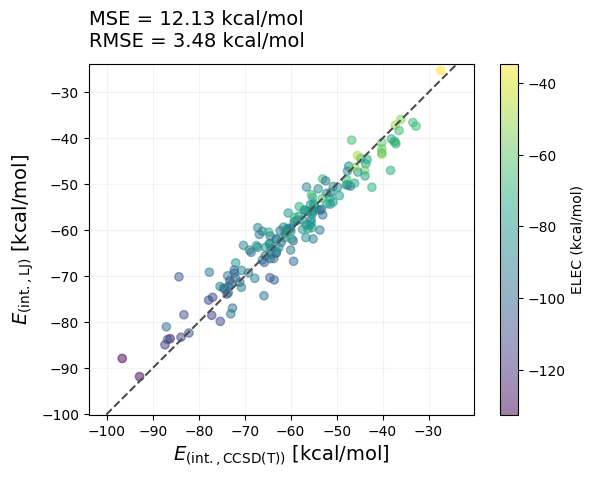

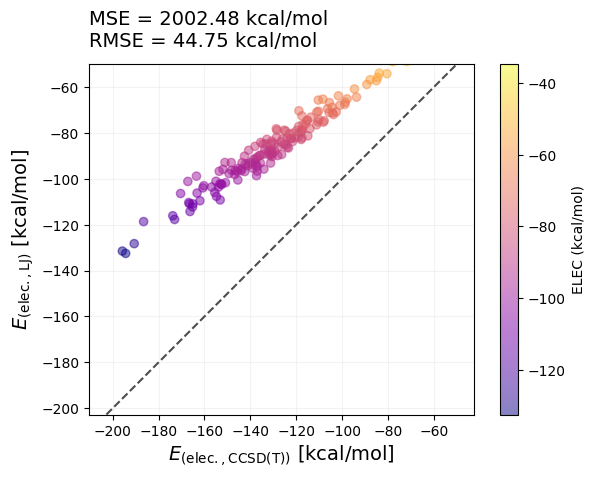

In [23]:
ff = prepare_FF_freeDE(cluster_flux)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_6, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("flux_fde_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("flux_fde_mse_ele.pdf", bbox_inches="tight")

flux_fde = ff

##  Kern-MDCM - free DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[ 1.80201449  0.07001781  0.14679272  0.02064464 20.          2.96908725]


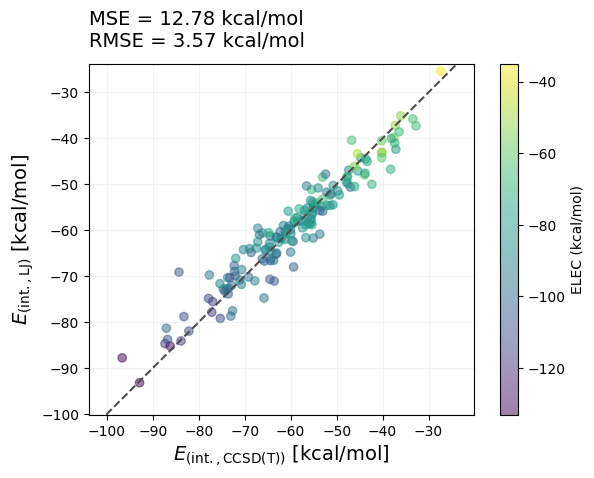

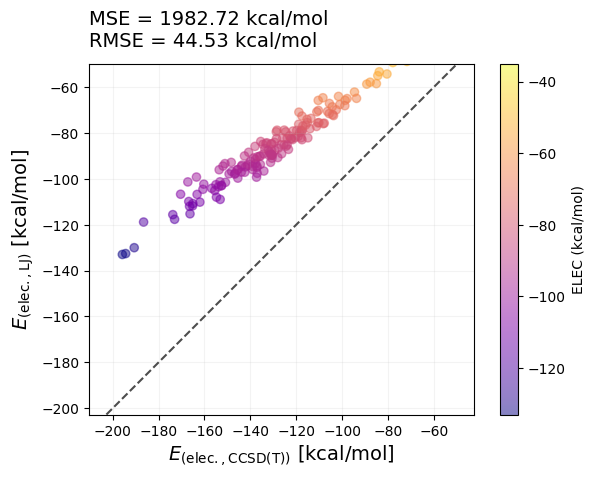

In [24]:
ff = prepare_FF_freeDE(cluster_kern)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_6, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("kern_fde_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("kern_fde_mse_ele.pdf", bbox_inches="tight")

kern_fde = ff

##  ELST - free DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.88267135e+00 7.12959049e-01 1.15972130e-01 1.00000000e-05
 1.68639353e+01 6.29335386e+00]


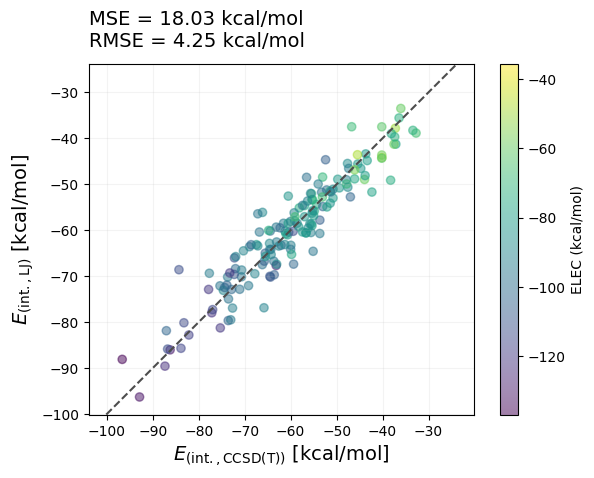

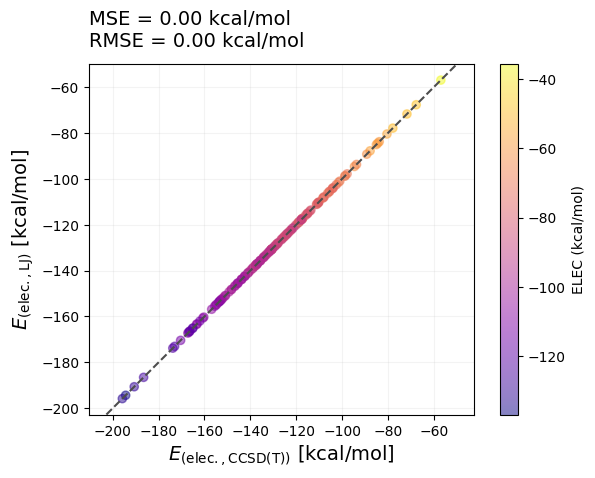

In [25]:
ff = prepare_FF_freeDE(cluster_mdcm, elec="ELST")

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_6, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("elst_fde_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", "ELST", 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("elst_fde_mse_ele.pdf", bbox_inches="tight")

elst_fde = ff



##  PC - free DE

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.70370838e+00 1.00000000e-04 2.83853072e-01 5.31432299e-01
 3.45519830e+00 2.00000000e+01]


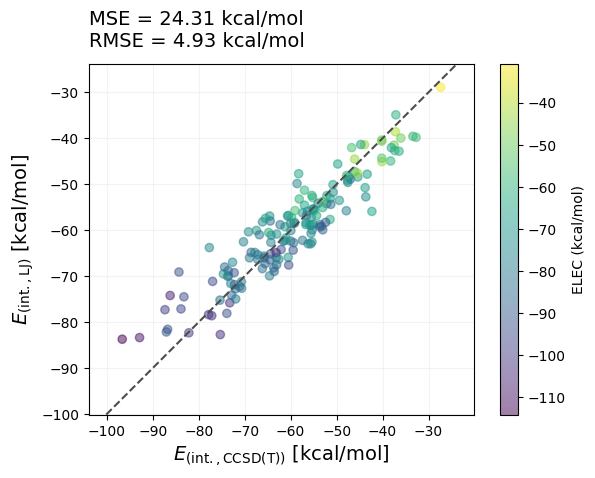

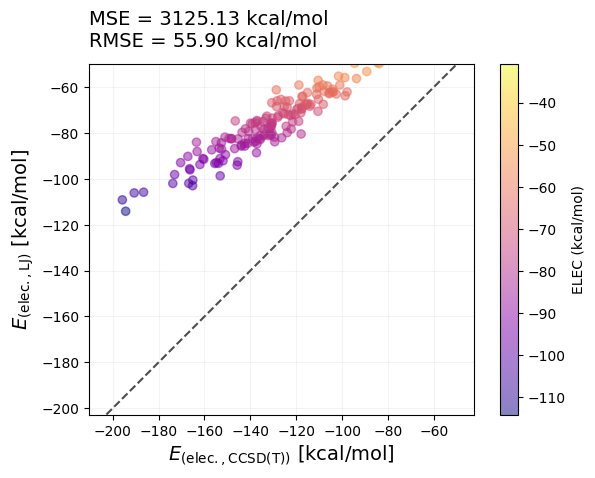

In [26]:
ff = prepare_FF_freeDE(cluster_pc)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_6, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("pc_fde_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("pc_fde_mse_ele.pdf", bbox_inches="tight")

pc_fde = ff

# LJ

In [27]:
N = 10

##  MDCM - LJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.78630102e+00 1.03169545e-04 2.18064380e-01 1.00000000e-05]


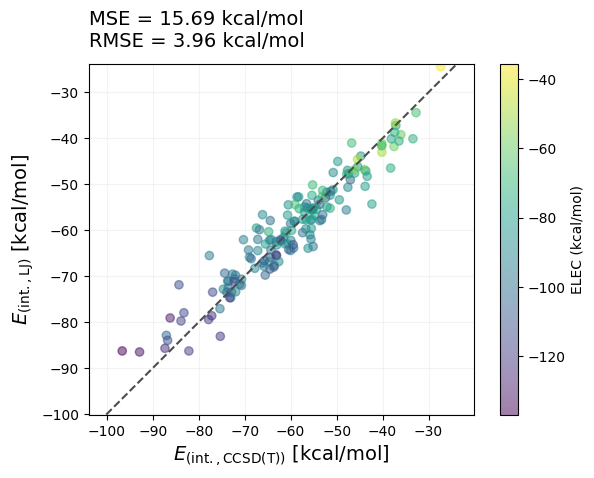

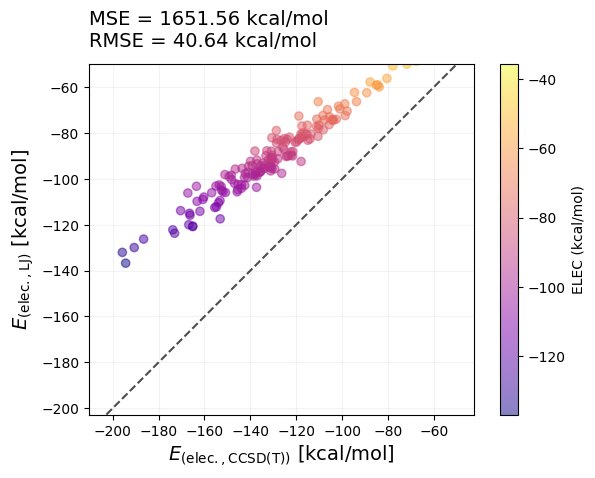

In [28]:
ff = prepare_FF_LJ(cluster_mdcm)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_lj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_lj_mse_ele.pdf", bbox_inches="tight")

mdcm_lj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


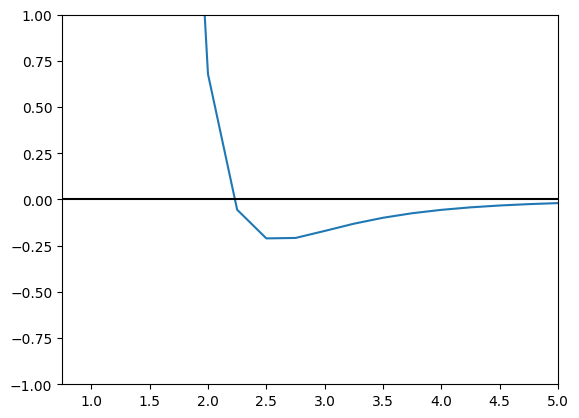

In [46]:
plot_2d(mdcm_lj)

##  f-MDCM - LJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.77804968e+00 1.00000000e-04 2.12237471e-01 4.01700485e-02]


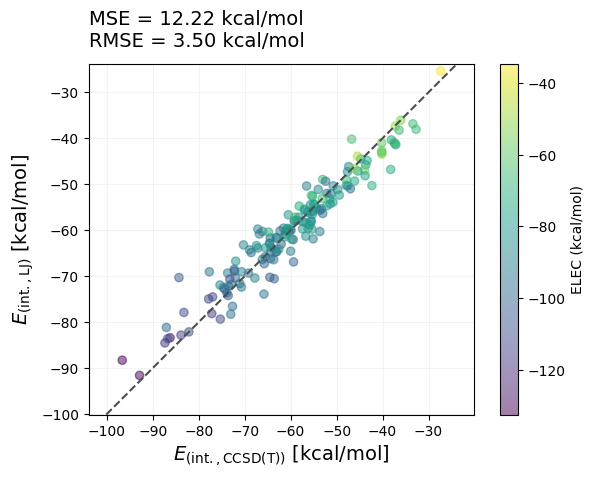

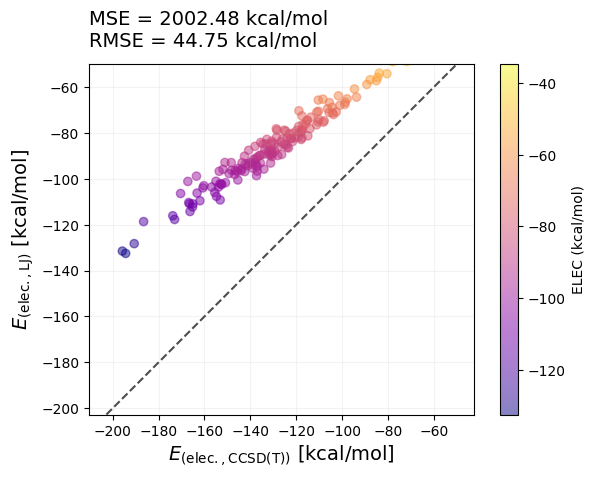

In [29]:
ff = prepare_FF_LJ(cluster_flux)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("flux_lj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("flux_lj_mse_ele.pdf", bbox_inches="tight")

flux_lj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


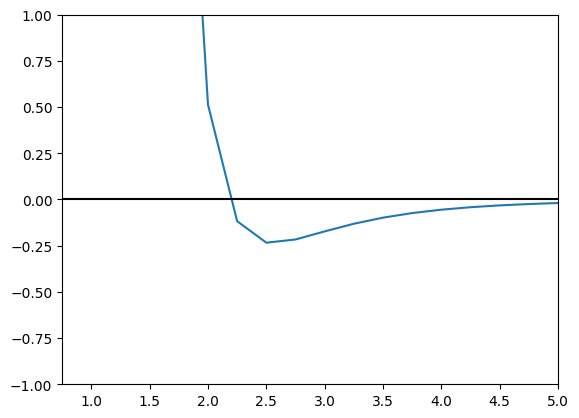

In [48]:
plot_2d(flux_lj)

##  Kern-MDCM - LJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.78246133 0.12241442 0.20216592 0.0189015 ]


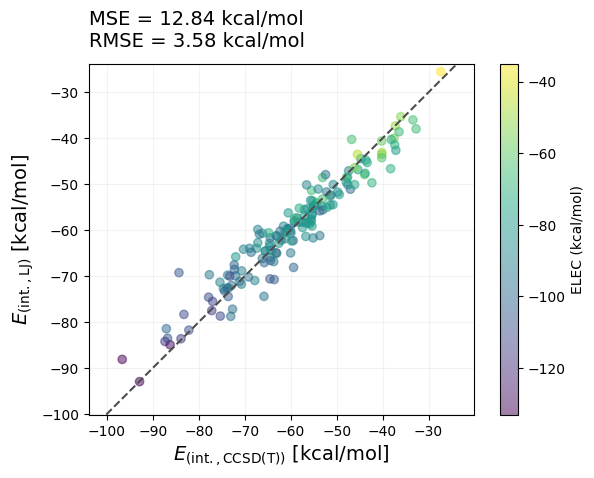

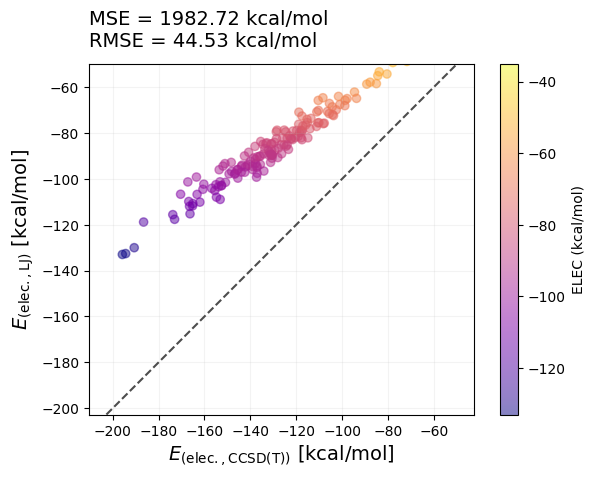

In [30]:
ff = prepare_FF_LJ(cluster_kern)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("kern_lj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("kern_lj_mse_ele.pdf", bbox_inches="tight")

kern_lj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


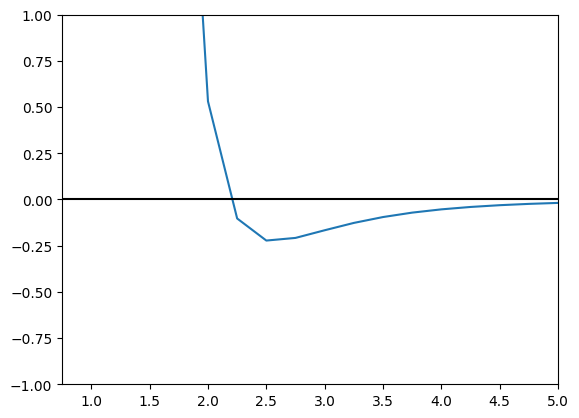

In [50]:
plot_2d(kern_lj)

##  ELST - LJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.96707967e+00 6.57915610e-01 9.70128062e-02 1.00000000e-05]


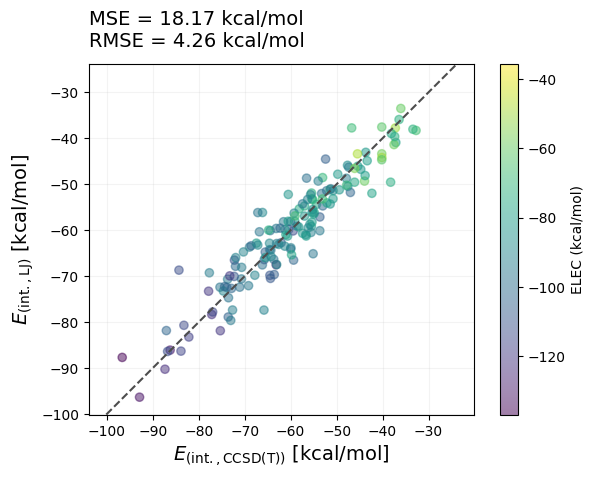

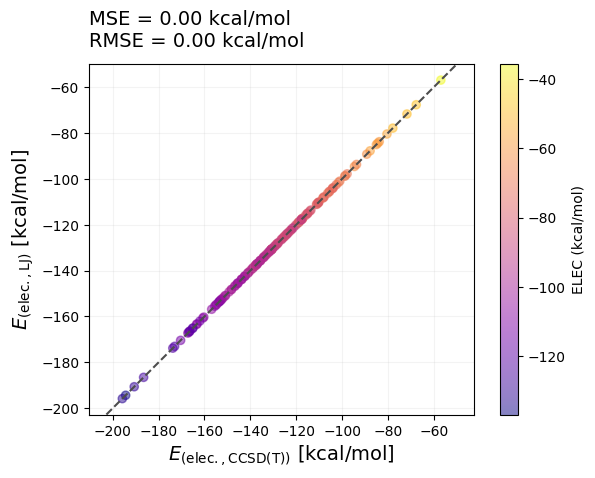

In [31]:
ff = prepare_FF_LJ(cluster_mdcm, elec="ELST")

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("elst_lj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", "ELST", 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("elst_lj_mse_ele.pdf", bbox_inches="tight")

elst_lj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


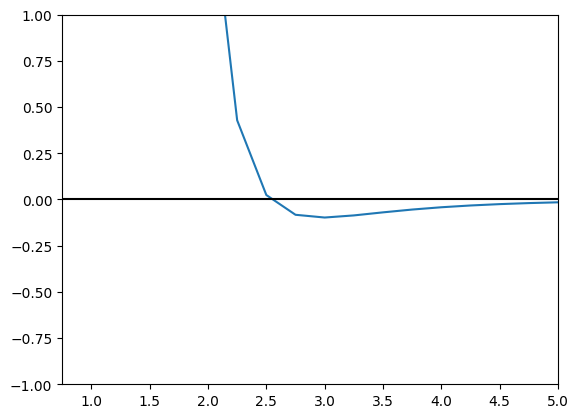

In [51]:
plot_2d(elst_lj)

##  PC - LJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.70394723e+00 8.49506424e-03 3.63338159e-01 1.00000000e-05]


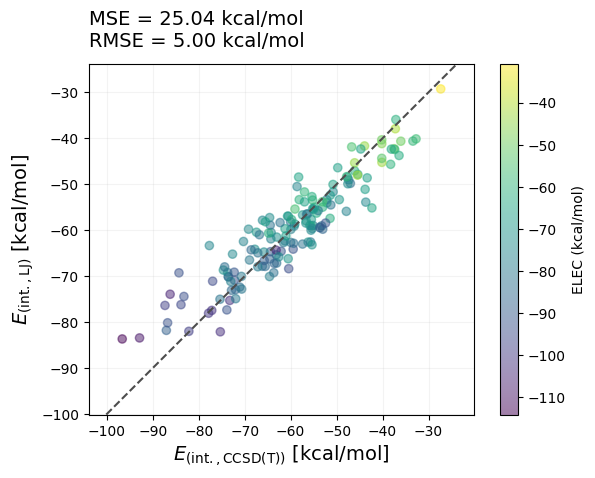

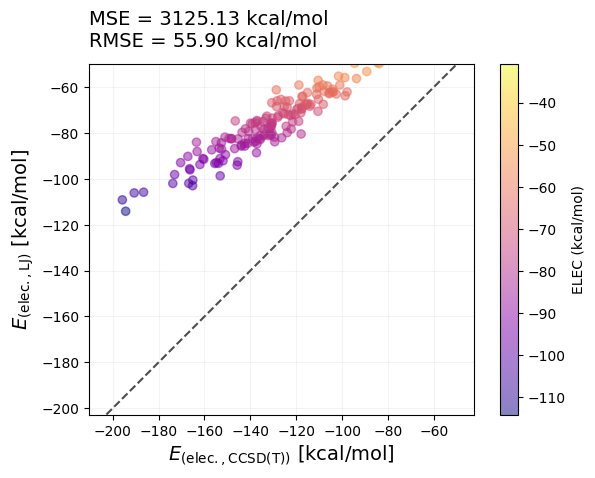

In [32]:
ff = prepare_FF_LJ(cluster_pc)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_4, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("pc_lj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("pc_lj_mse_ele.pdf", bbox_inches="tight")

pc_lj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


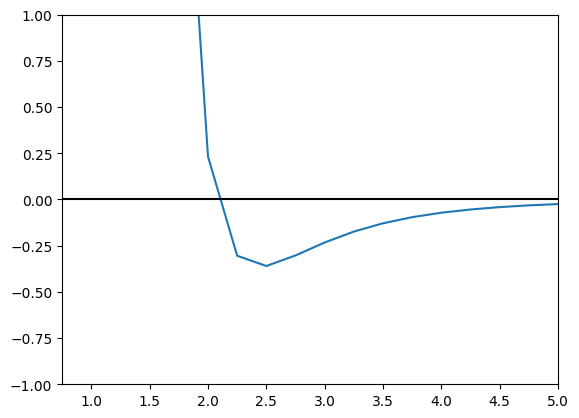

In [52]:
plot_2d(pc_lj)

#  free LJ

In [33]:
N = 50

##  MDCM - freeLJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[3.90000000e+00 1.00000018e-04 1.48495652e+00 1.07781660e+00
 9.04028541e+00 1.00012754e+00 1.00103953e+00]


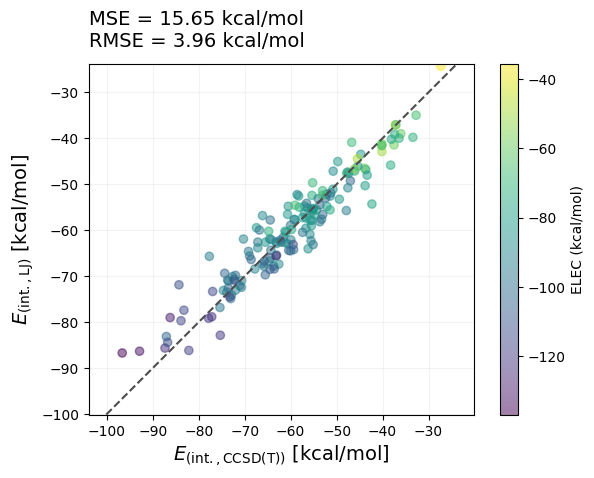

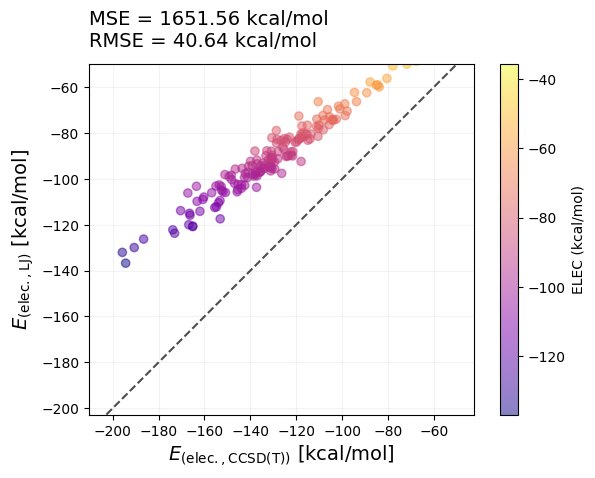

In [53]:
ff = prepare_FF_freeLJ(cluster_mdcm)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_7, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_flj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("mdcm_flj_mse_ele.pdf", bbox_inches="tight")

mdcm_flj = ff

### 2d

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


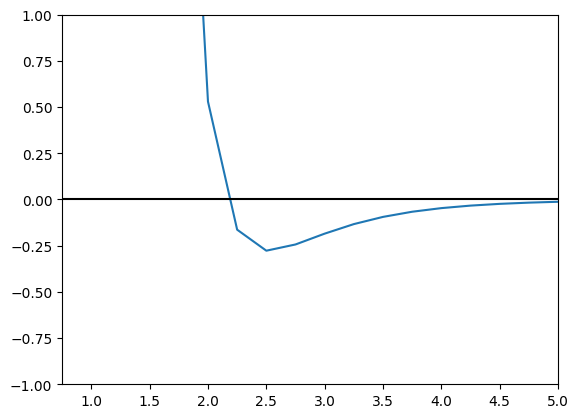

In [54]:
plot_2d(mdcm_flj)

##  f-MDCM - freeLJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.76337735e+00 1.00000000e-04 1.11233371e-01 1.20211450e-03
 4.91389553e+00 2.82246595e+00 2.53696153e+00]


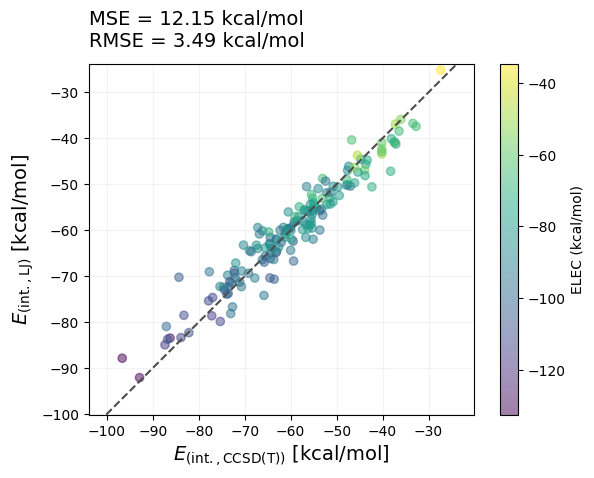

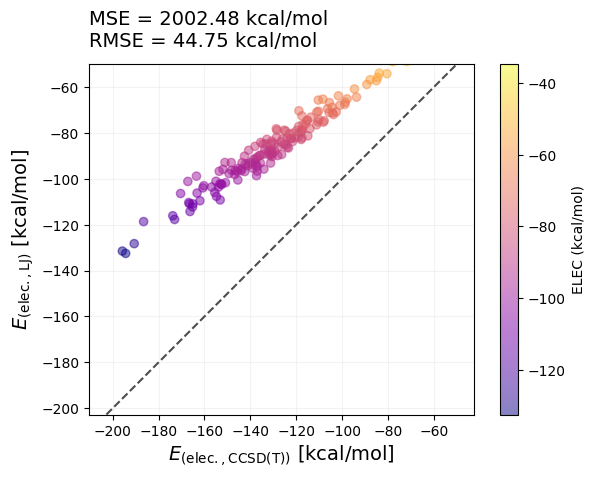

In [35]:
ff = prepare_FF_freeLJ(cluster_flux)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_7, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("flux_flj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("flux_flj_mse_ele.pdf", bbox_inches="tight")

flux_flj = ff

##  Kern-MDCM - freeLJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.72910963e+00 1.00000000e-04 1.38107773e-01 1.21396603e-02
 4.74867468e+00 2.94506219e+00 2.07550984e+00]


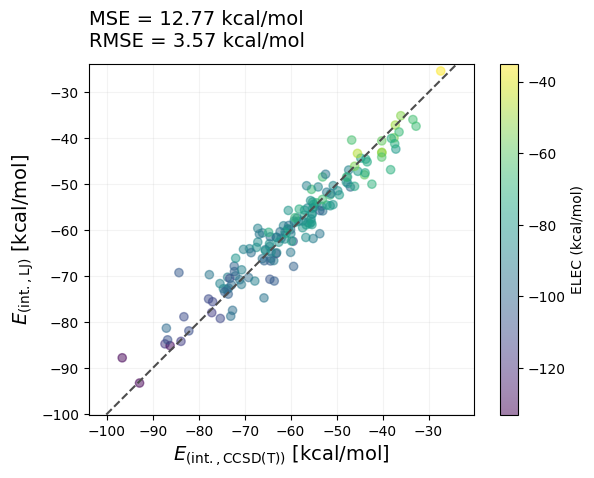

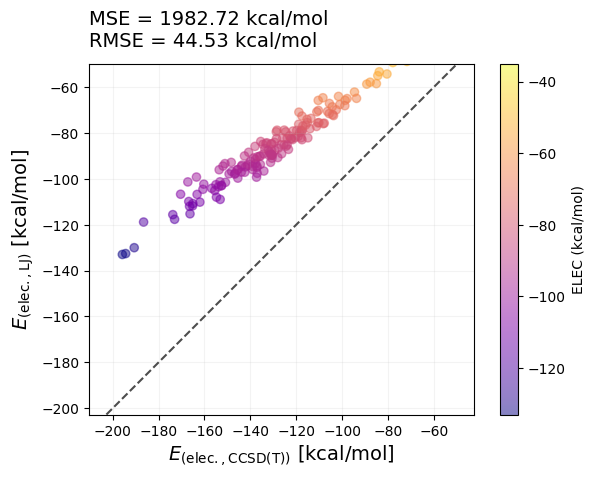

In [36]:
ff = prepare_FF_freeLJ(cluster_kern)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_7, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("kern_flj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("kern_flj_mse_ele.pdf", bbox_inches="tight")

kern_flj = ff

##  ELST - freeLJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[3.89999939e+00 3.83648976e-01 1.06640312e-03 3.66532120e-05
 8.77633594e+00 1.11098040e+00 2.21071828e+00]


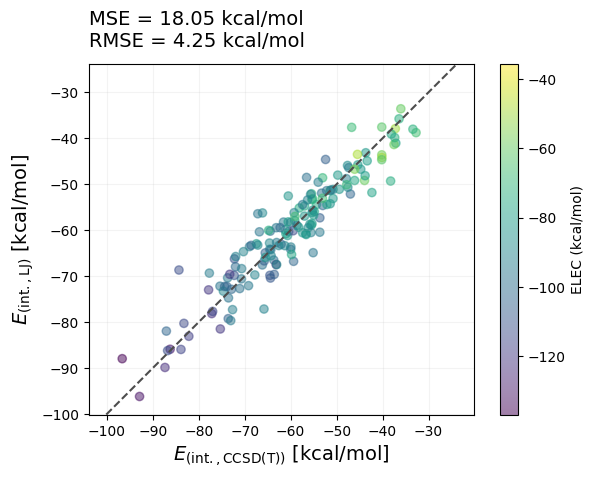

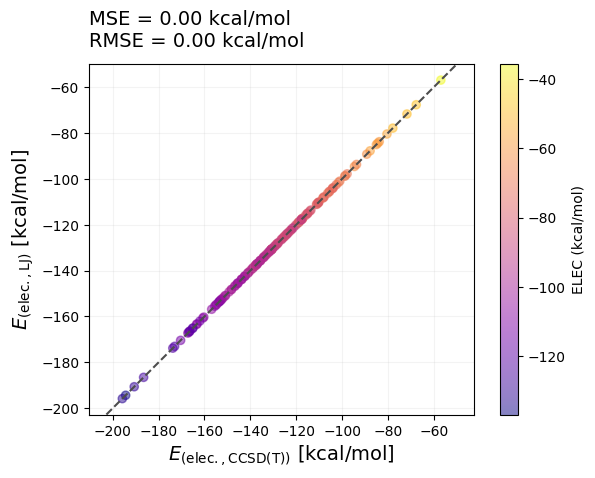

In [37]:
ff = prepare_FF_freeLJ(cluster_mdcm, elec="ELST")

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_7, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("elst_flj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", "ELST", 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("elst_flj_mse_ele.pdf", bbox_inches="tight")

elst_flj = ff

##  PC - freeLJ

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
Set optimized parameters to FF object, self.df["LJ"] is updated.
[1.57476432e+00 1.00002578e-04 3.15688704e-01 5.32583150e-01
 4.37685074e+00 3.71234892e+00 1.44531147e+00]


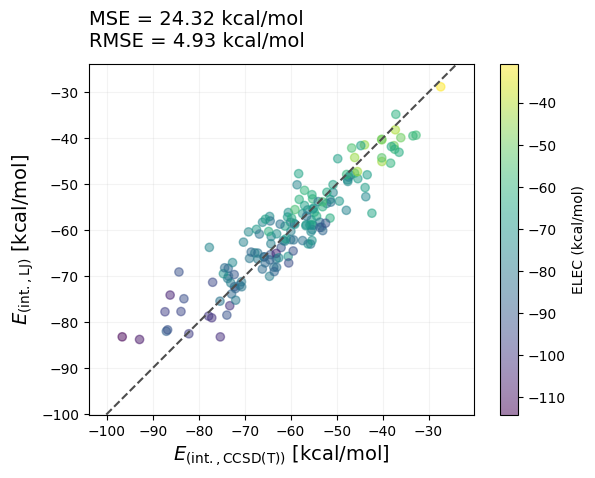

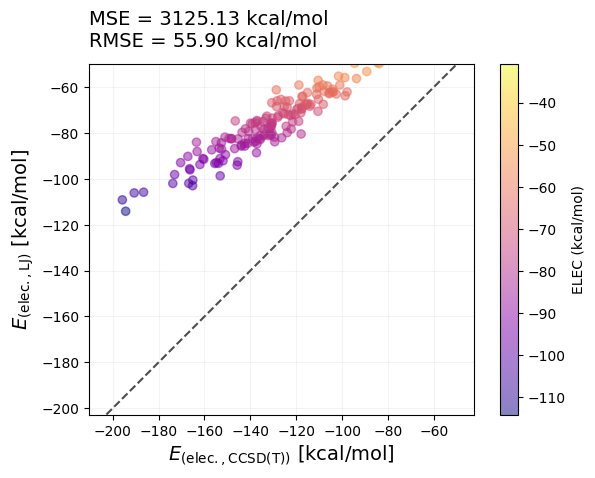

In [38]:
ff = prepare_FF_freeLJ(cluster_pc)

method = "Nelder-Mead"
ff.fit_repeat(N, bounds=bounds_7, method=method, quiet=True)

print(ff.opt_parm)

plot_energy_MSE(ff.df, "ETOT", "ETOT_LJ", 
                xlabel="$E_{\mathrm{(int., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(int., LJ)}}$ [kcal/mol]")

plt.savefig("pc_flj_mse.pdf", bbox_inches="tight")

plot_energy_MSE(ff.df, "ELST", elec, 
                CMAP="plasma",
                xlabel="$E_{\mathrm{(elec., CCSD(T))}}$ [kcal/mol]", 
                ylabel="$E_{\mathrm{(elec., LJ)}}$ [kcal/mol]")

plt.savefig("pc_flj_mse_ele.pdf", bbox_inches="tight")

pc_flj = ff

#  end